![image.png](attachment:image.png)

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [234]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [235]:
df = pd.read_pickle('/content/drive/MyDrive/base_nfp.pkl')
df.head(3)

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes


In [236]:
index = df.loc[df['Retorno'].isna()].index
df.drop(index, inplace=True)

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [237]:
# criando coluna para dias de semana

df['Dia_semana'] = df['Data Registro'].map(lambda x: x.day_name())

# criando coluna dummy para dias de final de semana

df['Fim_semana'] = False
df.loc[df['Dia_semana'].isin(['Saturday', 'Sunday']), 'Fim_semana'] = True

# criando coluna para dias de mês

df['Dia_mes'] = df['Data Registro'].map(lambda x: x.day)

# criando coluna para meses

df['Mes'] = df['Data Registro'].map(lambda x: x.month_name())

# criando coluna para trimestres

df['Trimestre'] = df['Data Registro'].map(lambda x: x.quarter)

# criando coluna ano-trimestre

df['ano_trimestre'] = (df['Ano'].astype(str) + '.' + df['Trimestre'].astype(str)).astype(float)

# Crie categorizações da variável Valor NF, por quantís, em 5, 10, 20 e 50 categorias.

df['valor_nf_5'] = pd.qcut(df['Valor NF'] , 5)
df['valor_nf_10'] = pd.qcut(df['Valor NF'] , 10)
df['valor_nf_20'] = pd.qcut(df['Valor NF'] , 20)
df['valor_nf_50'] = pd.qcut(df['Valor NF'] , 50)

## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [238]:
# criando o metadados

ttnc = df.copy()
ttnc.drop(columns=['No.', 'CNPJ emit.', 'Data Emissão', 'Data Registro', 'Emitente', 'Créditos', 'Valor NF'], inplace=True)
metadados = pd.DataFrame({'dtype':ttnc.dtypes})
metadados['papel'] = 'covariavel'
metadados.loc['flag_credito','papel'] = 'resposta'
metadados['nunique'] = ttnc.nunique()


In [239]:
# função para cálculo do IV das variáveis em um dataframe

def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [240]:
# Calculando o IV das variáveis

for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'nunique']>50):
        metadados.loc[var, 'IV'] = IV(pd.qcut(ttnc[var],5,duplicates='drop'), ttnc.flag_credito)
    else:
        metadados.loc[var, 'IV'] = IV(ttnc[var], ttnc.flag_credito)

metadados.sort_values('IV', ascending=False)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,dtype,papel,nunique,IV
Situação do Crédito,category,covariavel,3,inf
Retorno,float64,covariavel,60202,inf
categoria,object,covariavel,9,0.392961
valor_nf_50,category,covariavel,50,0.129105
valor_nf_20,category,covariavel,20,0.111032
ano_trimestre,float64,covariavel,20,0.093412
valor_nf_10,category,covariavel,10,0.093307
Dia_mes,int64,covariavel,31,0.073199
valor_nf_5,category,covariavel,5,0.050725
Ano,int64,covariavel,5,0.040141


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

<font color='red'>Verifica-se que as variáveis "categoria" e "valor_nf_50" apresentam os maiores IV</font>

<font color='red'>Observa-se que a categorização em maior número de grupos teve influência positiva no valor do IV</font>

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

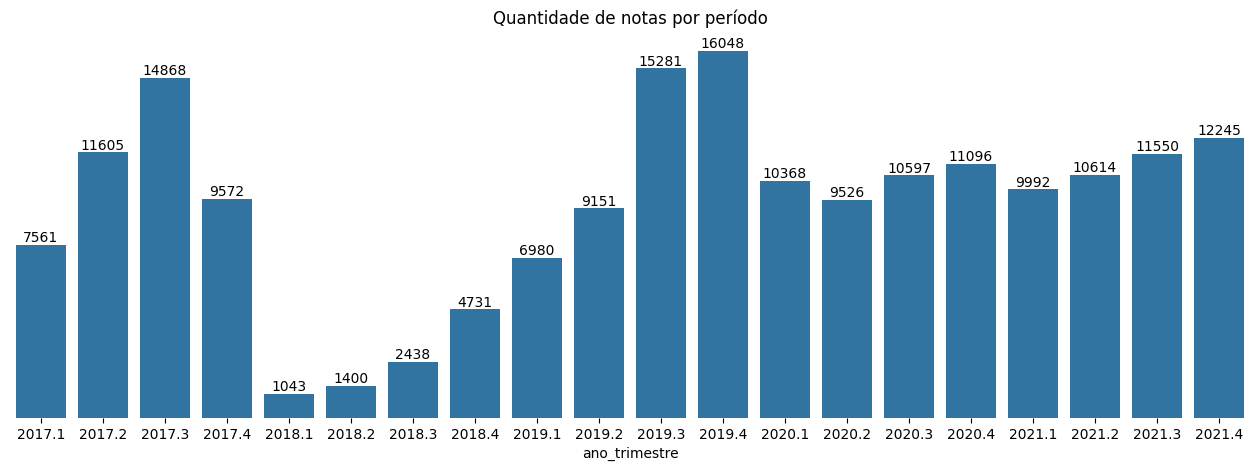

In [241]:
# A quantidade de notas registradas na base por período

fig, ax = plt.subplots(figsize=(16,5))
sns.countplot(x='ano_trimestre', data=df)
ax.set_title('Quantidade de notas por período')
ax.set_ylabel('')
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_yticks([])
ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
plt.show()


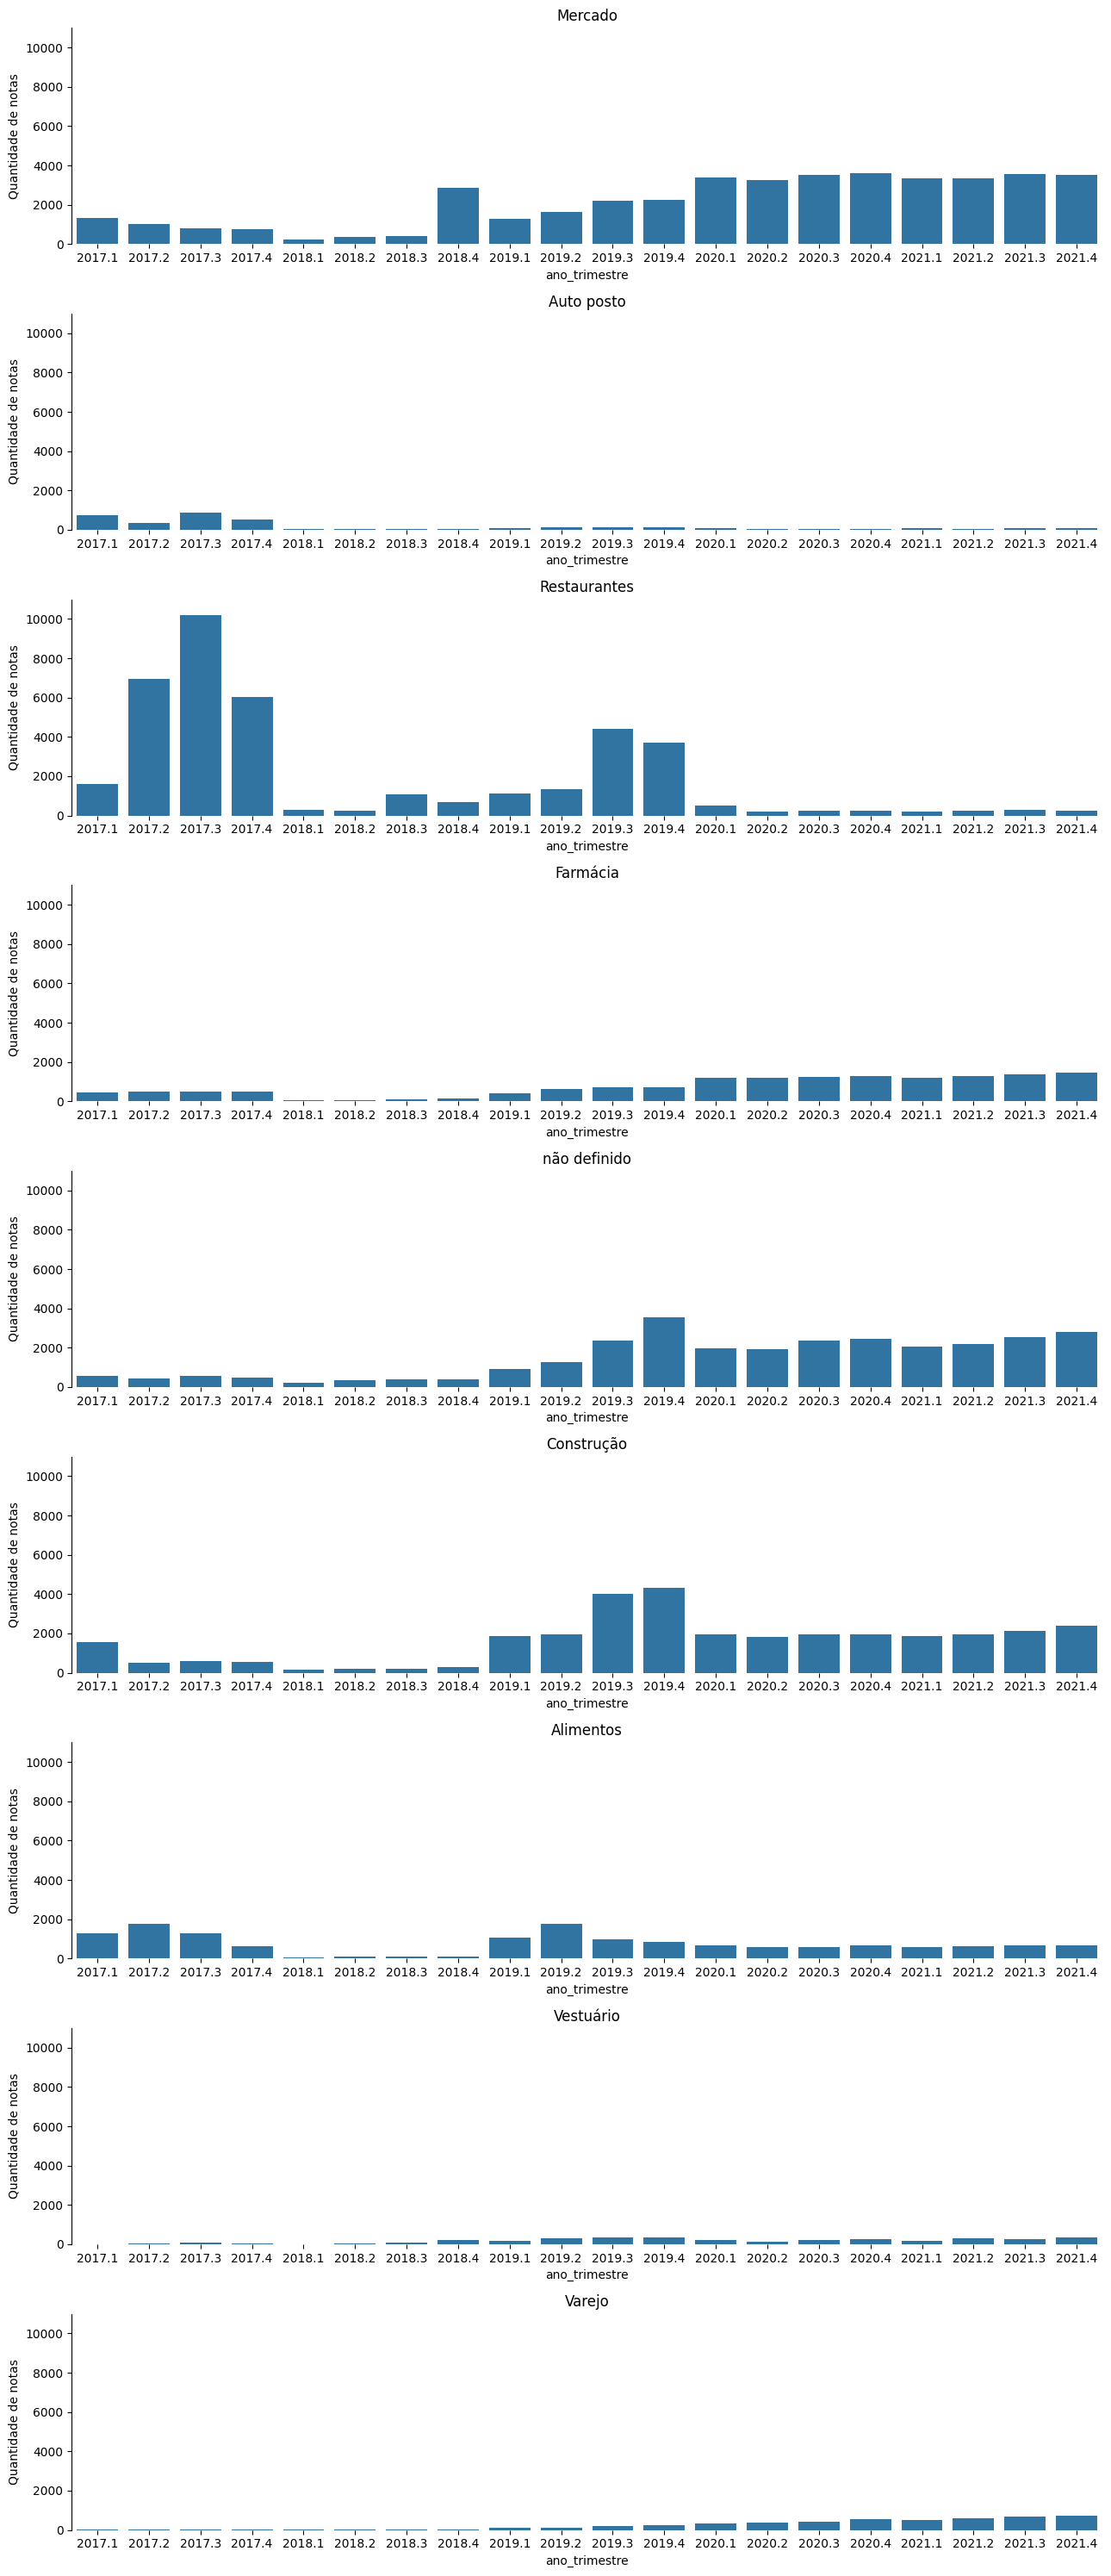

In [242]:
# A quantidade de notas por categoria e por período

categorias = df['categoria'].unique()
fig, ax = plt.subplots(len(categorias), 1,figsize=(13,30))

for i in range(len(categorias)):

  sns.countplot(x='ano_trimestre', data=df[df['categoria'] == categorias[i]], ax=ax[i])
  ax[i].set_title(categorias[i])
  ax[i].set_ylabel('Quantidade de notas')
  ax[i].set_ylim(0, 11000)
  ax[i].spines[['top', 'right', 'bottom']].set_visible(False)

plt.tight_layout()
plt.show()


In [243]:
# construindo dataframe com a proporcao de NF com crédito, por categoria e período

crosstab_2 = pd.crosstab(df.ano_trimestre, [df.categoria, df.flag_credito], margins=True, margins_name='total')

data_proporcao = pd.DataFrame()

for col in df['categoria'].unique():

  data_proporcao[col] = crosstab_2[col][1] / (crosstab_2[col][0] + crosstab_2[col][1])

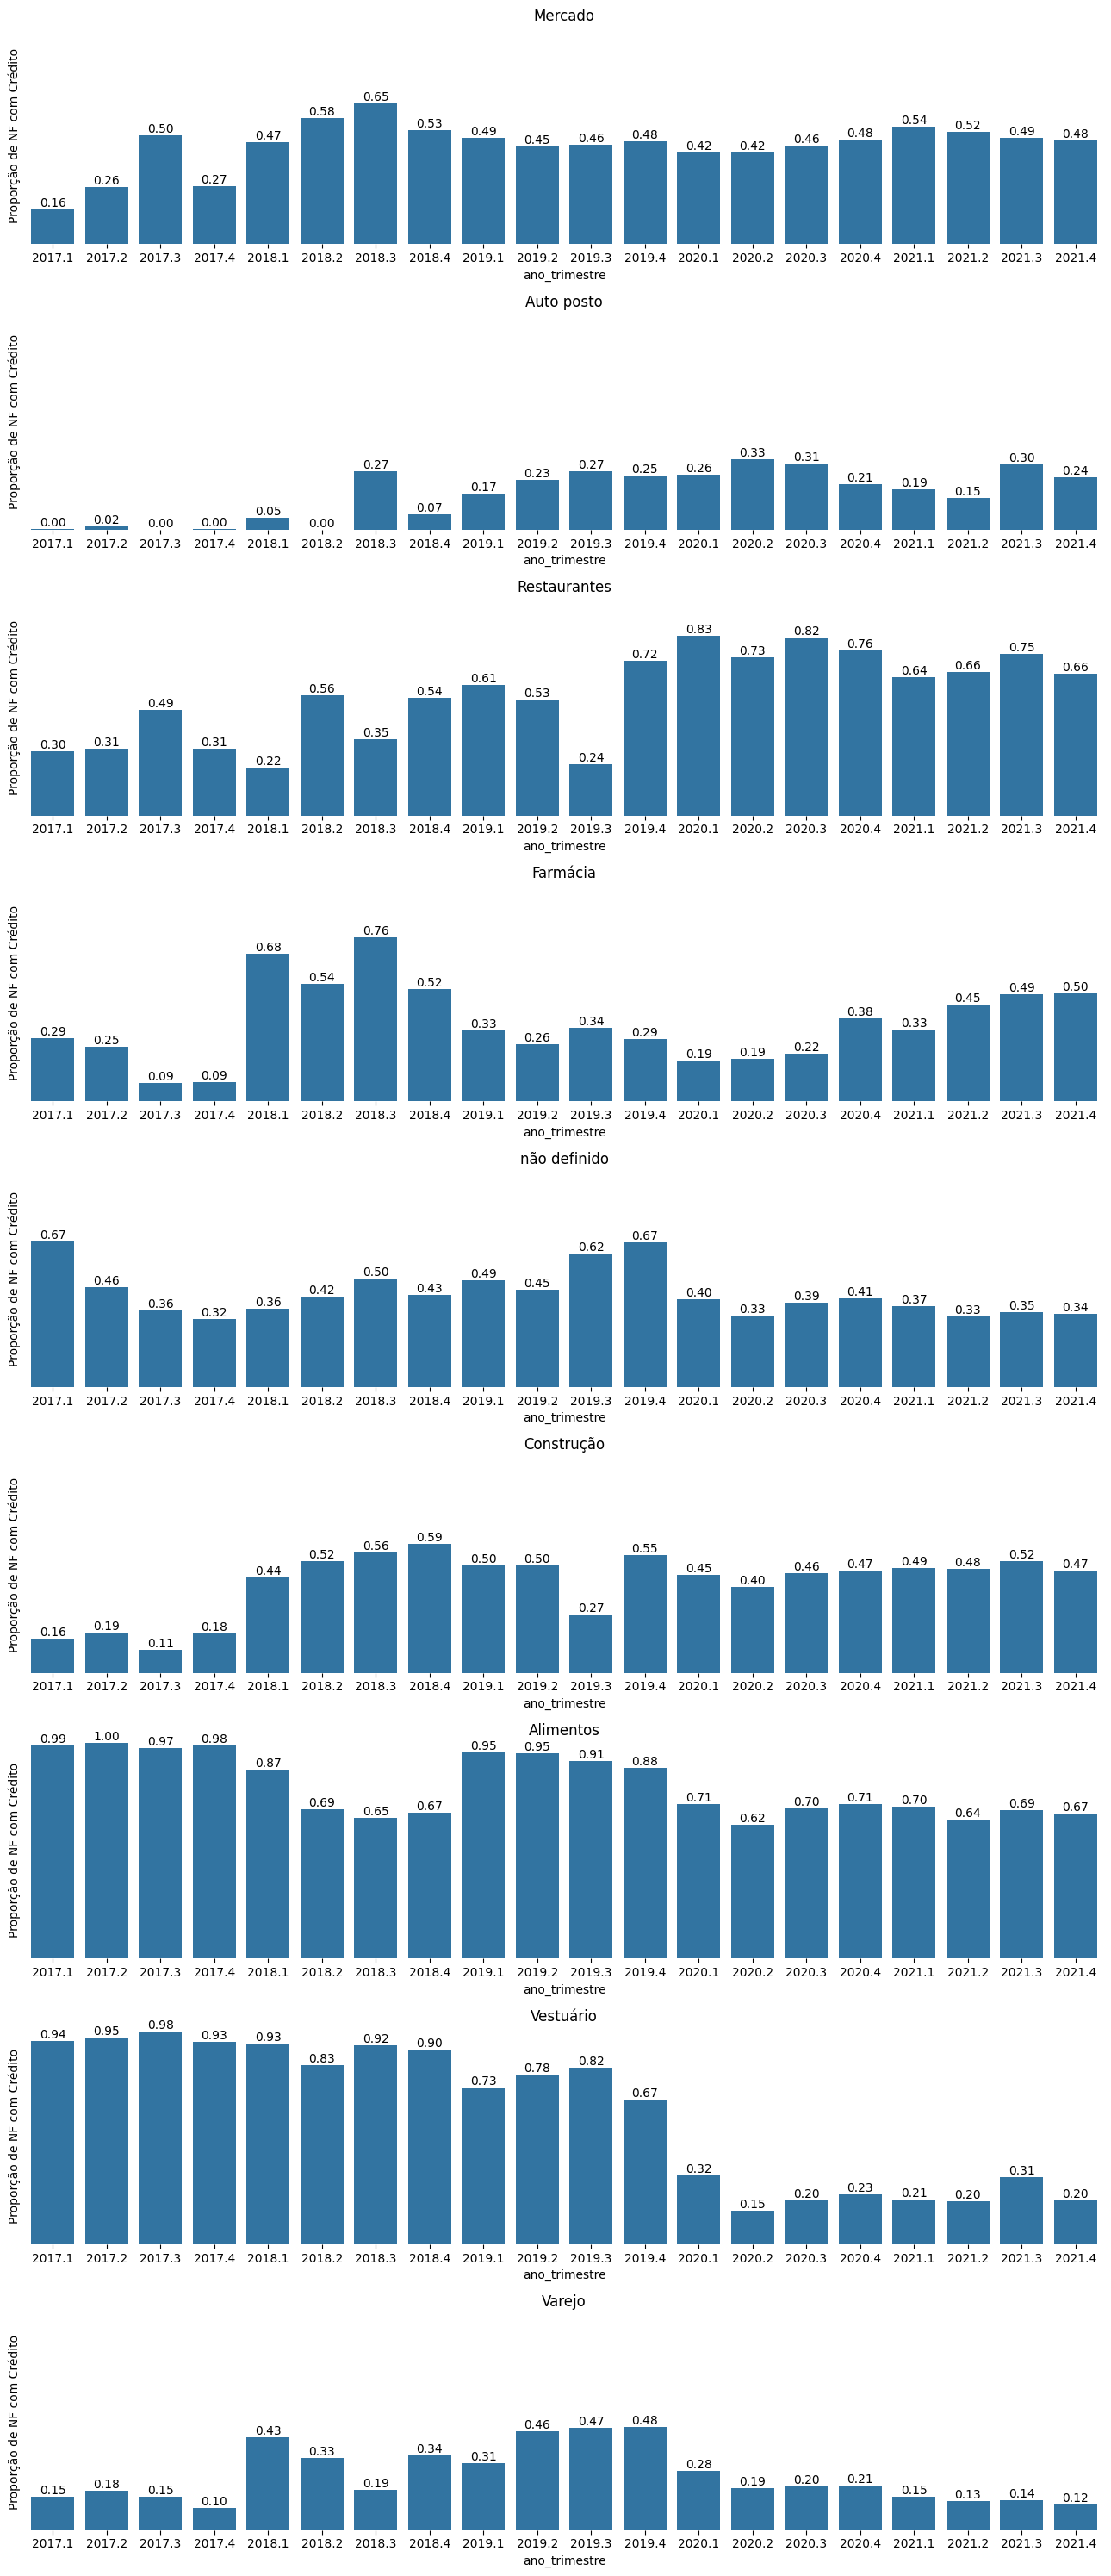

In [244]:
# A proporção de notas com crédito por categoria por período

fig, ax = plt.subplots(len(categorias), 1,figsize=(13,30))

for i in range(len(categorias)):

  sns.barplot(data=data_proporcao[categorias[i]][:-1], ax=ax[i])
  ax[i].set_title(categorias[i])
  ax[i].bar_label(ax[i].containers[0], fontsize=10, fmt=lambda x: f'{x:.2f}')
  ax[i].set_ylabel('Proporção de NF com Crédito')
  ax[i].set_yticks([])
  ax[i].set_ylim(0, 1)
  ax[i].spines[['left', 'top', 'right', 'bottom']].set_visible(False)

plt.tight_layout()
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [245]:
# separando os valores totais entre NFs com ou sem retorno positivo

for index in crosstab_2.index:

  crosstab_2.loc[index, ('all', 0)] = crosstab_2.loc[index, (   categorias,  0)].sum()
  crosstab_2.loc[index, ('all', 1)] = crosstab_2.loc[index, (   categorias,  1)].sum()

In [246]:
# construindo dataframe com a valores de WOE, por categoria e período

data_woe = pd.DataFrame()

for col in categorias:

  pct_nao_evento = crosstab_2[col][0] / crosstab_2['all'][0]
  pct_evento = crosstab_2[col][1] / crosstab_2['all'][1]
  rc = pct_evento / pct_nao_evento
  data_woe[col] = np.log(rc)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


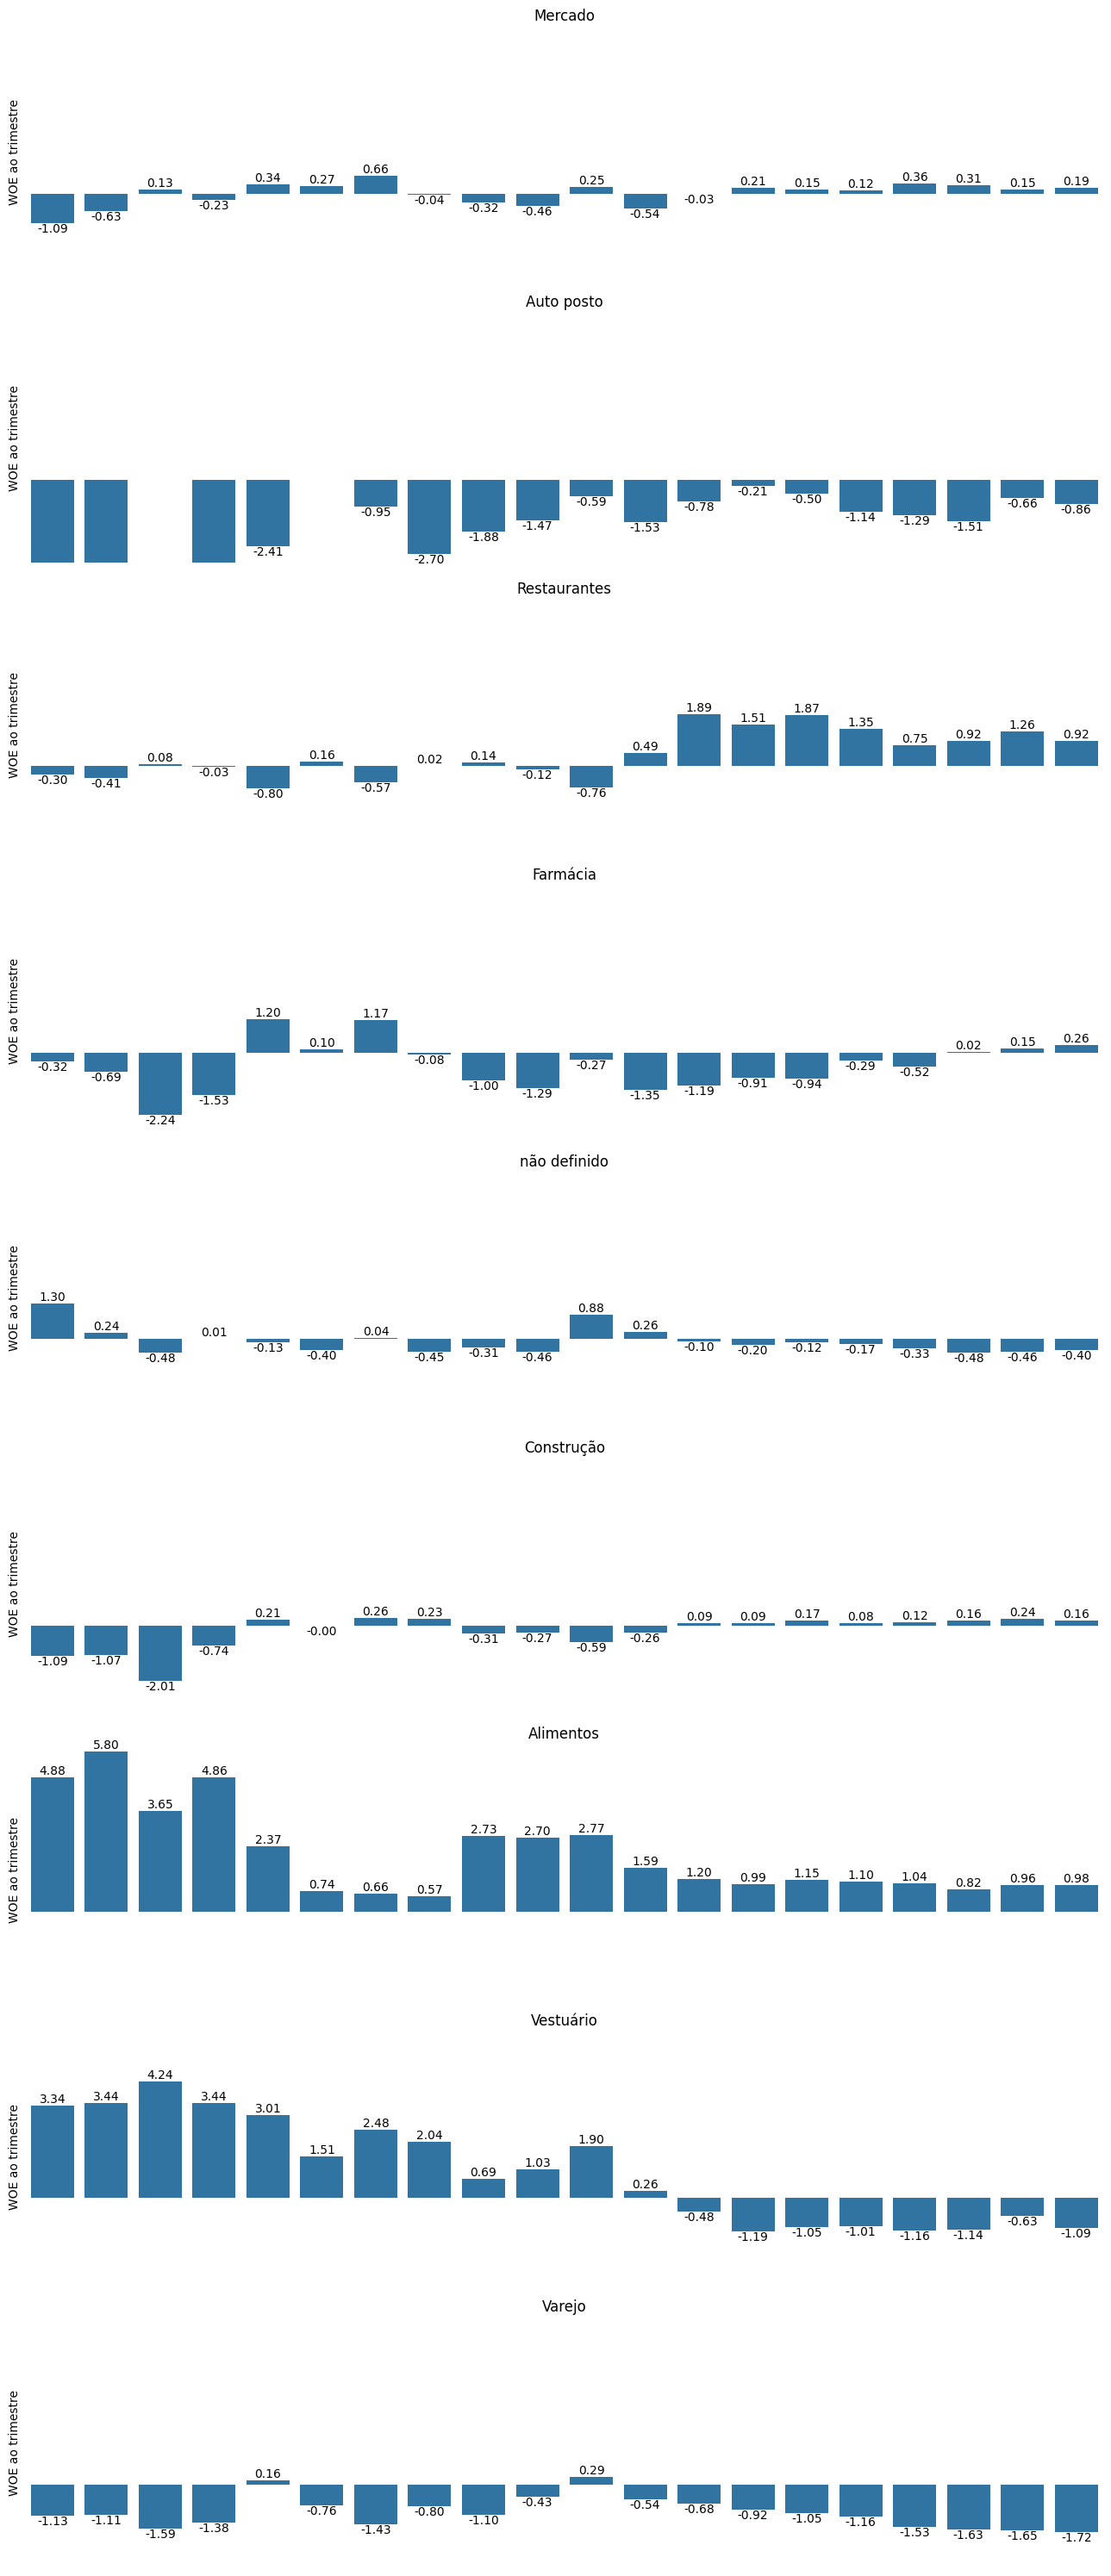

In [247]:
# plotando valores de WOE no tempo da variável categoria

fig, ax = plt.subplots(len(categorias), 1,figsize=(13,30))

for i in range(len(categorias)):

  sns.barplot(data=data_woe[categorias[i]][:-1], ax=ax[i])
  ax[i].set_title(categorias[i])
  ax[i].bar_label(ax[i].containers[0], fontsize=10, fmt=lambda x: f'{x:.2f}')
  ax[i].set_ylabel('WOE ao trimestre')
  ax[i].set_xlabel('')
  ax[i].set_yticks([])
  ax[i].set_xticks([])
  ax[i].set_ylim(-3, 6)
  ax[i].spines[['left', 'top', 'right', 'bottom']].set_visible(False)

plt.tight_layout()
plt.show()

In [248]:
# construindo dataframe com a valores de IV, por categoria e período

data_iv = pd.DataFrame()

for col in categorias:

  pct_nao_evento = crosstab_2[col][0] / crosstab_2['all'][0]
  pct_evento = crosstab_2[col][1] / crosstab_2['all'][1]
  rc = pct_evento / pct_nao_evento
  woe = np.log(rc)
  data_iv[col] = (pct_evento - pct_nao_evento) * woe

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


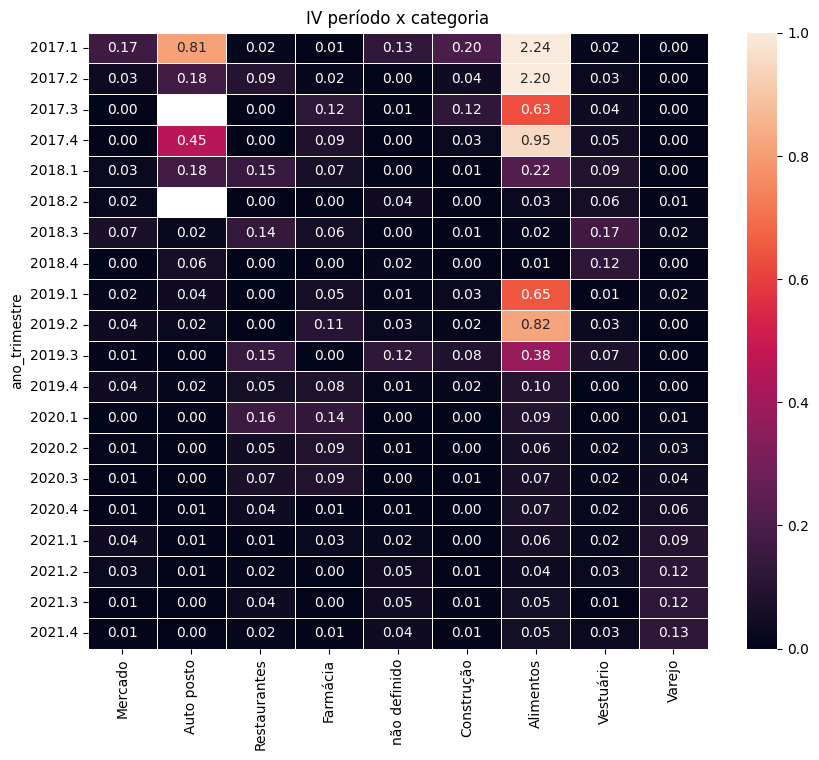

In [249]:
# plotando valores de IV no tempo da variável categoria

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(data_iv[:-1], annot=True, fmt='.2f', linewidth=.5, vmin=0, vmax=1)
ax.set_title('IV período x categoria')

plt.show()

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

<font color='red'>As categorias "Vestuários" e "Alimentos" aparentemente, ao longo do tempo, tem apresentado as maiores proporções de NF com retornos maiores que zero</font>

<font color='red'>As diferenças não são estáveis ao longo do tempo, tanto em termos de proporção de NF com retorno positivo, quanto de valores de WOE e de IV</font>